$\newcommand{\xv}{\mathbf{x}}
\newcommand{\Xv}{\mathbf{X}}
\newcommand{\yv}{\mathbf{y}}
\newcommand{\zv}{\mathbf{z}}
\newcommand{\av}{\mathbf{a}}
\newcommand{\Wv}{\mathbf{W}}
\newcommand{\wv}{\mathbf{w}}
\newcommand{\tv}{\mathbf{t}}
\newcommand{\Tv}{\mathbf{T}}
\newcommand{\muv}{\boldsymbol{\mu}}
\newcommand{\sigmav}{\boldsymbol{\sigma}}
\newcommand{\phiv}{\boldsymbol{\phi}}
\newcommand{\Phiv}{\boldsymbol{\Phi}}
\newcommand{\Sigmav}{\boldsymbol{\Sigma}}
\newcommand{\Lambdav}{\boldsymbol{\Lambda}}
\newcommand{\half}{\frac{1}{2}}
\newcommand{\argmax}[1]{\underset{#1}{\operatorname{argmax}}}
\newcommand{\argmin}[1]{\underset{#1}{\operatorname{argmin}}}$

# Assignment 3: Neural Network Regression

Yashad Samant

## Overview

The basis of the third assignment is to differentiate between the the linear regression model and neural network model. The performance of the linear model depends upon the parameter lambda. We learnt the importance of lambda in the previous assignment, the flexibility it provides to the model as related to the basic linear model. But then again flexibility provided by lambda in the equation is minimal as even if we change all the values in the equation: 
$$ \wv = (X^T X + \lambda I)^{-1} X^T T $$  
we don't get good outcomes as all the probabilities are not covered. But when we consider neural networks, though we are defining same random set of training, test and validate data as we are using in linear, we have many parameters to change the neural network model itself. We can change the number of hidden nodes, number of levels in hidden nodes, iterations the neural net will be having. Moreover, it's not just restricted to flexible parameters but they have a robust feedback network i.e. once the weigths for the neural net is calculated and the observed output is compared to desired output error is propagated to the input and weights are updated. This process is called back-propagation and is very effective. No doubt that linear model is very simple as compared to neural net and with the increase in lambda values, linear model doesn't become complex. In contrary to linear model, as we increase number of inputs, outputs, hidden layers or levels in hidden layers nueral network becomes more and more complex. Linear model doesn't have a substantial feedback so it takes less time to process while neural network on the other hand takes longer as compared to linear model. But this is a trade-off we have to consider for high accuracy. With the code below, I have implemented both linear model and neural net model and also observed and compared the rmse values from both models and notified the difference.    

In [1]:
# Libraries
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import neuralnetworks as nn
import scaledconjugategradient as scg
import mlutils as ml  # for draw()
import itertools

In [2]:
# Training definition for linear model
def trainLinear(X, T, lamb):
    means = X.mean(0)
    stds = X.std(0)
    n,d = X.shape
    Xs1 = np.insert( (X - means)/stds, 0, 1, axis=1)
    lambDiag = np.eye(d+1) * lamb
    lambDiag[0,0] = 0
    w = np.linalg.lstsq( Xs1.T.dot(Xs1) + lambDiag, Xs1.T.dot(T))[0]
    return {'w': w, 'means':means, 'stds':stds}

# Error calculation for Linear model
def evaluateLinear(model, X, T):
    Xs1 = np.insert((X-model['means'])/model['stds'], 0, 1, axis=1)
    A = Xs1.dot(model['w'])
    return np.sqrt(np.mean( (A-T)**2 ))

# Training definition for linear model
def trainNN(X, T, parameter):
    global nnet
    nnet = nn.NeuralNetwork(X.shape[1], parameter[0], 1)
    Model = nnet.train(X, T, parameter[1])
    return Model

# Error calculation for Linear model
def evaluateNN(Model, X, T):
    global Y
    Y = Model.use(X)
    return np.sqrt(np.mean(Y - T)**2)

In [3]:
# Defining K-fold validation
def trainValidateTestKFolds(trainNN,evaluateNN,X,T,parameterSets,nFolds, shuffle=False,verbose=False):
    global I 
    global IT 
    global O
    global OT
    global y1
    global y2 
    global paro
    
    # Randomly arrange row indices
    rowIndices = np.arange(X.shape[0])
    if shuffle:
        np.random.shuffle(rowIndices)
    # Calculate number of samples in each of the nFolds folds
    nSamples = X.shape[0]
    nEach = int(nSamples / nFolds)
    if nEach == 0:
        raise ValueError("partitionKFolds: Number of samples in each fold is 0.")
    # Calculate the starting and stopping row index for each fold.
    # Store in startsStops as list of (start,stop) pairs
    starts = np.arange(0,nEach*nFolds,nEach)
    stops = starts + nEach
    stops[-1] = nSamples
    startsStops = list(zip(starts,stops))
    # Repeat with testFold taking each single fold, one at a time
    
    # Initialization
    parameters = []
    result = []
    
    error_val = []
    error_train = []
    error_test = []
    error1_test = []
    error1_train = []   
    error = []
    besterror = 0.0
    mean = 0.0
    Xtn = []
    Ttn= []
    Xtst = []
    Ttst = []
    para = []
    paro = []
    I = []
    IT = []
    O = []
    OT = []
    y1 = []
    y2 = []
    count = 0
    # Main loop
    for testFold in range(nFolds):
        count = 0
        
        # Considering all parameter sets
            # Lambda for linear model
            # hidden layers and iterations for neural net
        for parmSet in parameterSets:
            # Repeating it again with validateFold taking each single fold, except for the testFold
               error = []
               # Repeating for nfolds 
               for validateFold in range(nFolds):
                    if testFold == validateFold:
                        continue
                    # trainFolds are all remaining folds, after selecting test and validate folds
                    trainFolds = np.setdiff1d(range(nFolds), [testFold,validateFold])
                    # Constructing Xtrain and Ttrain by collecting rows for all trainFolds
                    rows = []
                    for tf in trainFolds:
                        a,b = startsStops[tf]                
                        rows += rowIndices[a:b].tolist()
                    Xtrain = X[rows,:]
                    Ttrain = T[rows,:]
                    # Constructing Xval and Tval
                    a,b = startsStops[validateFold]
                    rows = rowIndices[a:b]
                    Xvalidate = X[rows,:]
                    Tvalidate = T[rows,:]
                    #Constructing Xtest and Ttest
                    a,b = startsStops[testFold]
                    rows = rowIndices[a:b]
                    Xtest = X[rows,:]
                    Ttest = T[rows,:]
                    # Check for implementation of linear model or neural net
                    if type(parameterSets[0]) == tuple:
                        model = trainNN(Xtrain,Ttrain,parmSet) 
                        err = evaluateNN(model,Xvalidate,Tvalidate)
                    else:
                        model = trainLinear(Xtrain,Ttrain,parmSet) 
                        err = evaluateLinear(model,Xvalidate,Tvalidate)                        
                    
                    # Storing all rmse values in a list
                    error.append(err) 
               # Mean of rmse errors      
               mean = np.mean(error)
               # Finding best error among different folds
               if (count == 0):
                    
                    besterror = mean
                    itrain = np.vstack((Xtrain, Xvalidate))
                    otrain = np.vstack((Ttrain, Tvalidate))
                    ival = Xvalidate
                    oval = Tvalidate
                    itest = Xtest
                    otest = Ttest
                    para = parmSet
                    
               if (count > 0) & (besterror > mean):
                    
                    besterror = mean
                    itrain = np.vstack((Xtrain, Xvalidate))
                    otrain = np.vstack((Ttrain, Tvalidate))
                    ival = Xvalidate
                    oval = Tvalidate
                    itest = Xtest
                    otest = Ttest
                    para = parmSet
                    
               count = count + 1 
               I.append(itrain)
               O.append(otrain)  
        # Check for linear model or neural net    
        if type(parameterSets[0]) == tuple:
            model = trainNN(itrain,otrain,para)
            error1_test.append(evaluateNN(model,itest,otest))
            IT.append(itest)
            y1.append(Y)
            OT.append(otest)
            error1_train.append(evaluateNN(model,itrain,otrain))
            y2.append(Y)
            import matplotlib.pyplot as plt
            plt.figure(figsize=(5,5))
            plt.subplot(nFolds, 1, 1)
            plt.plot(nnet.getErrors(), label = 'Error')
            plt.ylabel('Error')
            plt.xlabel('iterations')
            plt.title('Error trace')
           
        else:
            model = trainLinear(itrain,otrain,para)  
            err = evaluateLinear(model,itest,otest)
            error1_test.append(err)
            err = evaluateLinear(model,itrain,otrain)
            error1_train.append(err) 
        # Storing best parameters and error from three different sets in same list.    
        parameters.append(para)
        error_val.append(besterror)
    paro = parameters
    result = [parameters, error1_train, error_val, error1_test] 
    result = np.array(result).T
    return(result)

# Data

Data used in this problem is from University of California, Irvine Machine learning repository. It is segmented among the categorical data with 14 attributes. The attributes are as follows -:

    1. CRIM      per capita crime rate by town
    2. ZN        proportion of residential land zoned for lots over 
                 25,000 sq.ft.
    3. INDUS     proportion of non-retail business acres per town
    4. CHAS      Charles River dummy variable (= 1 if tract bounds 
                 river; 0 otherwise)
    5. NOX       nitric oxides concentration (parts per 10 million)
    6. RM        average number of rooms per dwelling
    7. AGE       proportion of owner-occupied units built prior to 1940
    8. DIS       weighted distances to five Boston employment centres
    9. RAD       index of accessibility to radial highways
    10.TAX      full-value property-tax rate per $10,000
    11. PTRATIO  pupil-teacher ratio by town
    12. B        1000(Bk - 0.63)^2 where Bk is the proportion of blacks 
                 by town
    13. LSTAT    % lower status of the population
    14. MEDV     Median value of owner-occupied homes in $1000's


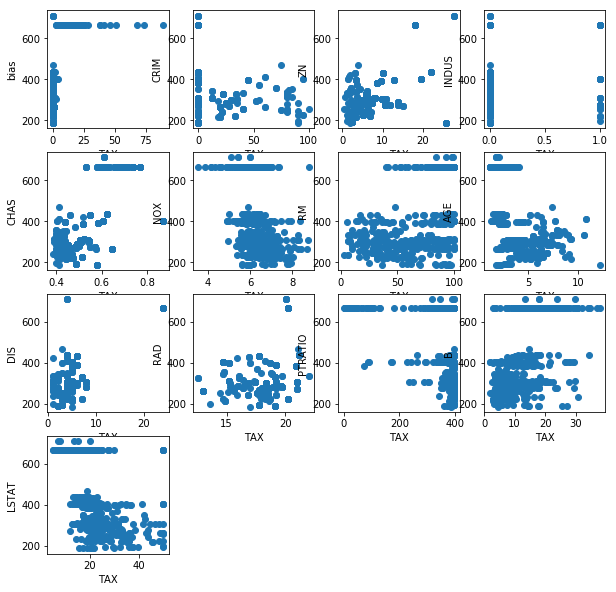

In [4]:
# Data same as A1
data = np.loadtxt("C:/Users/Yashad/Desktop/Books/machine learning/housing.data")

names =  ['CRIM','ZN','INDUS','CHAS','NOX',
          'RM','AGE','DIS','RAD','TAX','PTRATIO','B','LSTAT','MEDV']

#Separating TAX & storing in variable T
T = data[:, [9]] 
X = data[:, [0,1,2,3,4,5,6,7,8,10,11,12,13]] 

Xnames = ['CRIM','ZN','INDUS','CHAS', 'NOX',
          'RM','AGE','DIS','RAD','PTRATIO','B','LSTAT','MEDV']  
Tname = names[9] # Assigning TAX to Tname
Xnames.insert(0, 'bias') # adding bias column(ones) 

#Plotting tax with respect to other elements to check dependence
plt.figure(figsize=(10,10))
nrow,ncol = X.shape
for c in range(ncol):
    plt.subplot(4,4, c+1)
    plt.plot(X[:,c],T,'o')
    plt.ylabel(Xnames[c])
    plt.xlabel(Tname)

Linear Model
  lambda        train   validate  test RMSE
  20.00        58.825     79.420     45.885
  20.00        46.854     62.017    108.882
  10.00        58.336     79.423     55.069
  100.00       61.099    105.973     69.288
  100.00       57.512     88.264     87.508


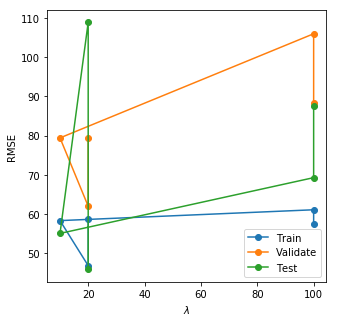

In [5]:
# Calling function K-folds
result = trainValidateTestKFolds(trainLinear, evaluateLinear ,X, T, range(0,101,10), nFolds=5, shuffle=False)
print('Linear Model\n{:^10s} {:>10s} {:>10s} {:>10s}'.format('lambda', 'train', 'validate', 'test RMSE'))
for x in result:
    print('{:^10.2f} {:>10.3f} {:10.3f} {:10.3f}'.format(*x))

# Linear model plot    
plt.figure(figsize=(5,5))
plt.plot(result[:,0],result[:,1:],'-o')
plt.xlabel('$\lambda$')
plt.ylabel('RMSE')
plt.legend(('Train','Validate','Test'),loc='best')

NN Model
    (Hidden Units, Iterations)      train   validate  test RMSE
                       (5, 10)      5.324     31.372     14.939
                 ([5, 5], 500)      0.015     11.776     73.884
                     (20, 100)      0.069     22.584     30.320
                      (20, 10)      2.683     65.436      2.206
                      (2, 500)      0.160     34.061     12.114


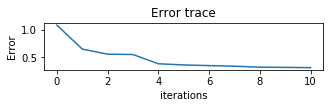

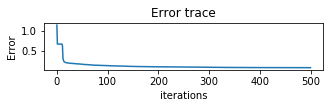

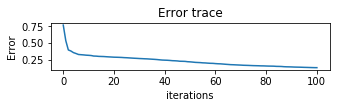

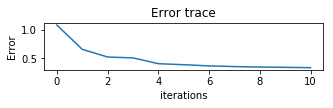

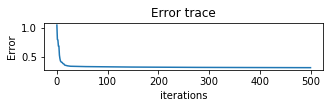

In [6]:
# Defining parameter set for neural network
parms = list(itertools.product([2, 5, 10, 20, [5, 5], [10, 2, 10]], [10, 20, 100, 500]))
nFolds = 5
result = trainValidateTestKFolds(trainNN, evaluateNN, X, T, parms, nFolds, shuffle=False);
print('NN Model\n{:>30s} {:>10s} {:>10s} {:>10s}'.format('(Hidden Units, Iterations)', 'train', 'validate', 'test RMSE'))
for x in result:
     print('{:>30s} {:10.3f} {:10.3f} {:10.3f}'.format(str(x[0]), *x[1:]))


I = np.array(I)
O = np.array(O)
y1 = np.array(y1)
y2 = np.array(y2)
IT = np.array(IT)
OT = np.array(OT)

## Example

Linear Model
  lambda        train   validate  test RMSE
  100.00        4.614      4.614      6.202
  100.00        5.071      5.282      3.457
  10.00         3.640      3.806      7.221
  40.00         4.362      4.188      6.068
   0.00         4.370      4.825      6.401
NN Model
    (Hidden Units, Iterations)      train   validate  test RMSE
                       (2, 10)      0.189      2.484      4.211
                       (5, 10)      0.026      2.437      0.799
                  ([5, 5], 20)      0.008      2.180      2.492
                       (5, 10)      0.053      3.115      0.905
                  ([5, 5], 10)      0.412      1.661      3.309
('SCG stopped after', 92, 'iterations:', 'limit on f Precision')
Fold Number 1
('Final RMSE: train', 1.4994527506854258, 'test', 2.9412208425438706)
('SCG stopped after', 101, 'iterations:', 'did not converge')
Fold Number 2
('Final RMSE: train', 0.082905323902320846, 'test', 0.0071004847358239424)
('SCG stopped after', 101, 'it

C:\Users\Yashad\Anaconda2\lib\site-packages\matplotlib\pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


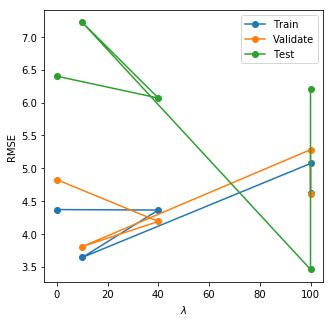

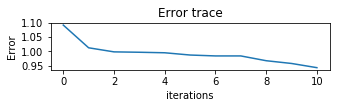

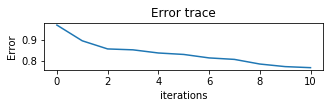

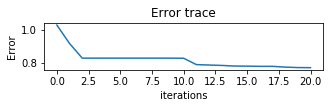

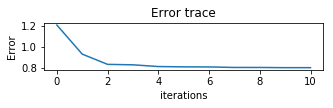

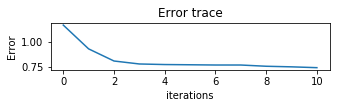

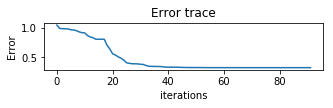

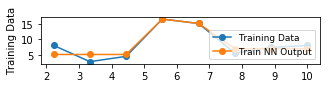

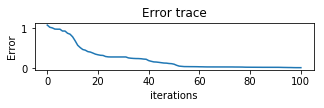

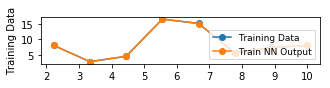

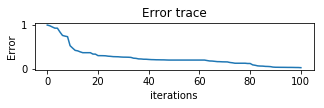

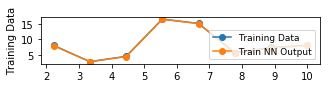

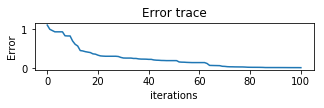

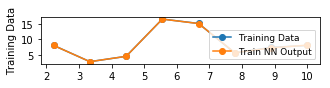

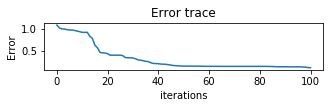

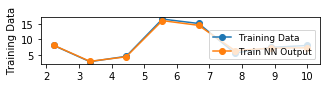

In [7]:
nSamples = 10
X = np.linspace(0, 10, nSamples).reshape((-1, 1))
T = 1.5 + 0.6 * X + 0.8 * np.sin(1.5*X)
T[np.logical_and(X > 2, X < 3)] *= 3
T[np.logical_and(X > 5, X < 7)] *= 3
result = trainValidateTestKFolds(trainLinear, evaluateLinear ,X, T, range(0,101,10), nFolds=5, shuffle=False)
print('Linear Model\n{:^10s} {:>10s} {:>10s} {:>10s}'.format('lambda', 'train', 'validate', 'test RMSE'))
for x in result:
    print('{:^10.2f} {:>10.3f} {:10.3f} {:10.3f}'.format(*x))

plt.figure(figsize=(5,5))
plt.plot(result[:,0],result[:,1:],'-o')
plt.xlabel('$\lambda$')
plt.ylabel('RMSE')
plt.legend(('Train','Validate','Test'),loc='best')
parms = list(itertools.product([2, 5, 10, 20, [5, 5], [10, 2, 10]], [10, 20, 100, 500]))
result = trainValidateTestKFolds(trainNN, evaluateNN, X, T, parms, nFolds=5, shuffle=False);
print('NN Model\n{:>30s} {:>10s} {:>10s} {:>10s}'.format('(Hidden Units, Iterations)', 'train', 'validate', 'test RMSE'))
for x in result:
     print('{:>30s} {:10.3f} {:10.3f} {:10.3f}'.format(str(x[0]), *x[1:]))

import matplotlib.pyplot as plt
import imp
I = np.array(I)
O = np.array(O)
y1 = np.array(y1)
y2 = np.array(y2)
IT = np.array(IT)
OT = np.array(OT)
nFolds = 5
for i in range(nFolds):
    
    pa = paro[i]
    nnet = nn.NeuralNetwork(1, pa[0] , 1)

    nnet.train(I[i], O[i], errorPrecision=1.e-10, weightPrecision=1.e-10, nIterations=100)
    print("SCG stopped after", nnet.getNumberOfIterations(), "iterations:", nnet.reason)
    Y = nnet.use(I[i])
    plt.figure(figsize=(15, 15))

    nHLayers = len(nnet.nhs)
    nPlotRows = 3 + nHLayers
   
    plt.figure(figsize=(5,5))
    plt.subplot(nFolds, 1, 1)
    plt.plot(nnet.getErrors(), label = 'Error')
    plt.ylabel('Error')
    plt.xlabel('iterations')
    plt.title('Error trace')
    print('Fold Number %d'%(i+1))
    
    plt.figure(figsize = (5,5))
    plt.subplot(nFolds, 1, 2)
    plt.plot(I[i], O[i], 'o-', label='Training Data')
    plt.plot(I[i], Y, 'o-', label='Train NN Output')
    plt.ylabel('Training Data')
    plt.legend(loc='lower right', prop={'size':9})

    Ytest, Ztest = nnet.use(IT[i], allOutputs=True)
    print("Final RMSE: train", np.sqrt(np.mean((Y-O[i])**2)), "test", np.sqrt(np.mean((Ytest-OT[i])**2))) 

## Results

1. In case of linear model, we know that it works the best when lambda = 0 but I have implemented linear model on two datasets and we see that we frequently obtain decent results at $lambda$ = 100. But still the error distribution seems to be random and there is no proportionality between the two. Now ofcourse we are considering the lambda values for various folds and then calculating the mean but still no sign of proprtionality.
2. While considering neural network, we see there is proportionality between error and number of hidden layers, number of iterations. When we increase number of interations, we see there is a significant reduction in percent error. When we increase the number of hidden layers, we see decrease in error.  
3. If we compare the result obtained, we see relatively the validation error is more as compared to training and test set because initially model is trained on validation set. Now, when we compare the two models, we see the error obtained via linear model is very high as compared to neural network, because of the feedback involved in the neural network.
4. If we see the difference in the error values between the two models, neural network shows significant difference in the error, thus reducing it to such a value which may not be obtained by linear model at all. Hence, we conclude that the complexity of the neural network is not a big factor when it comes to the accuracy provided by the neural network.  

## Grading

Your notebook will be run and graded automatically. Download [A3grader.tar](http://www.cs.colostate.edu/~anderson/cs480/notebooks/A3grader.tar) and extract `A3grader.py` from it. Run the code in the following cell to demonstrate an example grading session.  You should see a perfect score of 80/100 if your functions are defined correctly.  The remaining 20% will be based on the instructors reading of your notebooks.  We will be looking for how well the method is explained in text with some LaTeX math, and how well the results are summarized.

 Testing: result = trainValidateTestKFolds(trainLinear,evaluateLinear,X,T,
                  range(0,101,10),nFolds=5,shuffle=False)
 Your result is
    10   3.158   4.132   2.414
    20   4.368   5.021   3.641
    10   3.245   4.178   5.03
    20   4.448   6.07   2.024
    20   2.426   2.972   10.89
20/20 points. First column, of best lambda values, is correct.
20/20 points. Columns of RMSE values are correct.
()
 Testing:
   import itertools
   parms = list(itertools.product([[5],[5,5],[2,2,2]], [10,50,100,200]))
   te = []
   for rep in range(5):
       result = trainValidateTestKFolds(trainNN,evaluateNN,X,T,
                                        parms,
                                        nFolds=4,shuffle=False)
       resulte = np.array([r[1:] for r in result])
       meanTestRMSE = resulte[:,-1].mean()
       print('     ',meanTestRMSE)
       te.append(meanTestRMSE)
('     ', 1.515375074797527)
('     ', 2.6251987443261644)
('     ', 1.242069364451073)


scaledconjugategradient.py:104: RuntimeWarning: divide by zero encountered in double_scalars
  alpha = -mu/delta
neuralnetworks.py:92: RuntimeWarning: invalid value encountered in add
  Zprev = np.tanh(Zprev.dot(V[1:,:]) + V[0:1,:])  # handling bias weight without adding column of 1's


('     ', 1.2318578930355715)
('     ', 1.6433429473173606)
40/40 points. Mean test RMSE is less than 5 as it should be.

C:\Users\Yashad\Desktop\Books\machine learning Grade is 80/100
Up to 20 more points will be given based on the qualty of your descriptions of the method and the results.


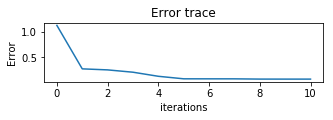

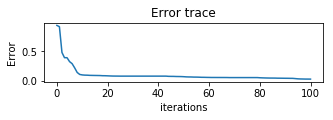

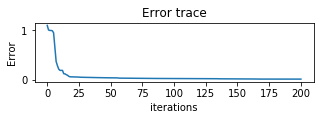

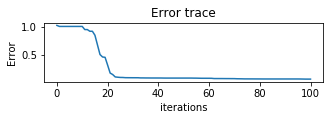

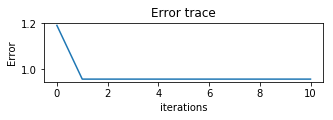

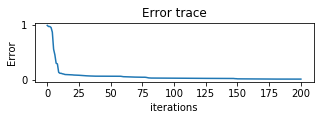

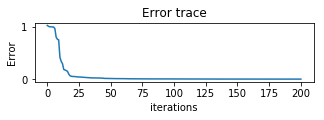

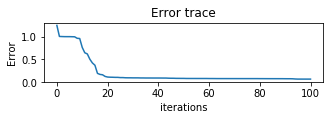

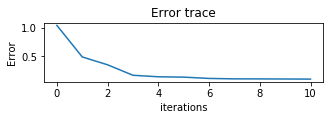

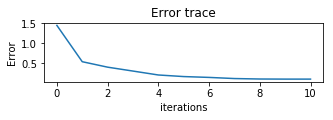

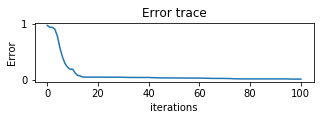

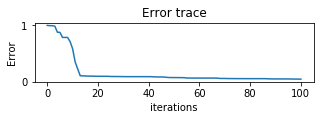

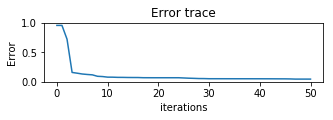

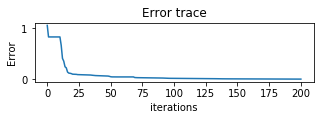

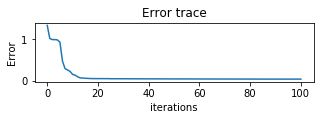

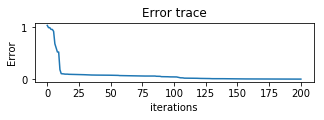

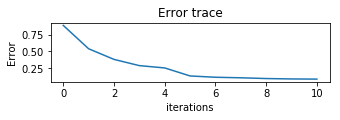

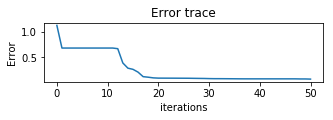

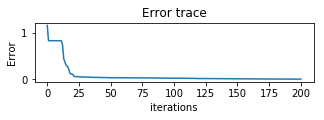

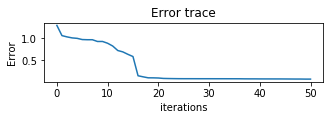

In [8]:
%run -i "A3grader.py"

## Check-in

Do not include this section in your notebook.

Name your notebook ```Lastname-A3.ipynb```.  So, for me it would be ```Anderson-A3.ipynb```.  Submit the file using the ```Assignment 3``` link on [Canvas](https://colostate.instructure.com/courses/41327).

Grading will be based on 

  * correct behavior of the required functions,
  * readability of the notebook,
  * effort in making interesting observations, and in formatting your notebook.